# Self-Driving Car Engineer Nanodegree


## Project: Vehicle Detection and Tracking
---
The goal of this project is to create a software pipeline to identify vehicles in a video from a front-facing camera on a car. 

The goals / steps of this project are the following:
* Perform a [Histogram of Oriented Gradients (HOG)](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector (optionally).
* Normalize extracted features and randomize a selection for training and testing.
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (start with the [test_video.mp4](test_video.mp4) and later implement on full [project_video.mp4](project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

This notebook is using python modules from [p5lib](p5lib/) package created for this project. Some of the modules were adopted from the class quiz example code. 

### Perform a [Histogram of Oriented Gradients (HOG)](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier ###

**1. Data Exploration**

Load project dataset from the `data/` folder 

In [1]:
from p5lib.data_preparation import data_load

# Dataset directories
cars_dir = 'data/vehicles'
notcars_dir = 'data/non-vehicles'

# load dataset images
cars, notcars = data_load(cars_dir, notcars_dir)
print('Loaded', len(cars), ' cars and', len(notcars), ' non-cars')

Loaded 8792  cars and 8968  non-cars


The datasets of cars and notcars images are roughly balanced. Plot random example images

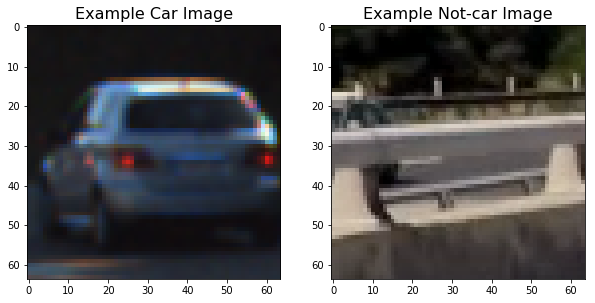

In [2]:
from p5lib.visualize import plt_two
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
# Visualize
figure = plt_two(car_image, notcar_image, 'Example Car Image', 'Example Not-car Image', figsize=(10,10), fontsize=16)
figure.savefig('output_images/car_notcar_example.jpg')   # save the figure to file
plt.close(figure)    # close the figure

Suffle and get characteristics of the dataset

In [3]:
from p5lib.data_preparation import data_look
from sklearn.utils import shuffle
import numpy as np

# Shuffle the files before feature extraction
rand_state = np.random.randint(0, 100)
cars = shuffle(cars, random_state=rand_state)
notcars = shuffle(notcars, random_state=rand_state)

data_info = data_look(cars, notcars)

print('The dataset contains', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


The dataset contains 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


**2. Explore color space featurs**

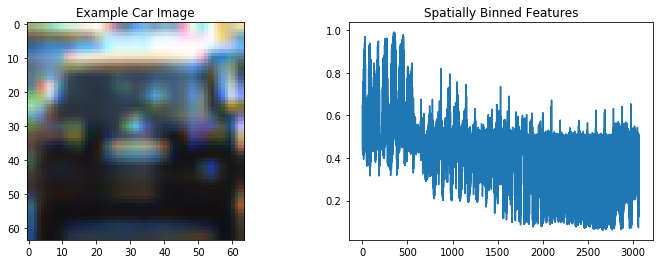

In [4]:
from p5lib.features import *
import matplotlib.pyplot as plt
%matplotlib inline

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
image = mpimg.imread(cars[ind])

# Define color channels and the spatial bin size
color_space='YCrCb' #'RBG' #'LUV' #'HSV' 
spatial_size=(32, 32)

feature_vec = get_bin_spatial(image, color_space=color_space, size=spatial_size)

# Plot the example features
figure = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()
figure.tight_layout()
#figure.savefig('output_images/spatially_binned.jpg')   # save the figure to file
plt.close(figure)    # close the figurefrom p5lib.features import *

**2. HOG feature extruction**


In [5]:
from p5lib.features import *
import numpy as np
import time

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
color_space='YCrCb'
hog_channel='ALL'
hog_feat=True

# Spatial parameters
spatial_size=(32, 32)
spatial_feat=True

# Histogram parameters
hist_bins=32
hist_feat=True

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')

# Measure time of feature extraction
t1=time.time()
print('Extracting HOG features...')

# Exctract cars features
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Exctract notcars features
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vector X
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Define the labels vector y
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Extracted', len(car_features), 'car features and', len(notcar_features),'non-car features')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Extracting HOG features...
563.77 Seconds to extract HOG features...
Extracted 8792 car features and 8968 non-car features


**3. Normalize extracted features**

In [6]:
from sklearn.preprocessing import StandardScaler
import time

# Measure time of feature normalization
t1=time.time()
print('Normalizing features...')

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

t2 = time.time()
print(round(t2-t1, 2), 'Seconds to normalize', len(scaled_X), 'features...')

Normalizing features...
4.53 Seconds to normalize 17760 features...


**4. Randomize a selection for training and testing**

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify=y)
print('Feature vector train set length:', X_train.shape[0], ', test set length:', X_test.shape[0])

Feature vector train set length: 14208 , test set length: 3552


**5. Train Linear SVM classifier and check performance**

In [8]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
import time

# Check the training time for the SVC
t=time.time()
print('Training SVC...')

# Use a linear SVC classifier 
svc= LinearSVC()

# Parameter tuning
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = SVC()
#svc = GridSearchCV(svr, parameters)
svc.fit(X_train, y_train)

#svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Training SVC...
50.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
2.4648 Seconds to predict 10 labels with SVC


Save training parameters for later use

In [9]:
import pickle

# Save the training parameters for later use
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["spatial_size"] = spatial_size
svc_pickle["hist_bins"] = hist_bins
svc_pickle["hog_channel"] = hog_channel

#pickle.dump(svc_pickle, open( "p5lib/svc_pickle.p", "wb" ) )
pickle.dump(svc_pickle, open( "p5lib/linear_svc_pickle.p", "wb" ) )
print('Saved')

Saved


In [20]:
import pickle

# Load training parameters
svc_pickle = pickle.load( open("p5lib/svc_pickle.p", "rb" ) )
svc_p = svc_pickle["svc"]

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_p.score(X_test, y_test), 4))

# Check the prediction time for a single sample
n_predict = 10
print('SVC predicts: ', svc_p.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9842
SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]


### Implement a sliding-window technique and use the trained classifier to search for vehicles in images ###

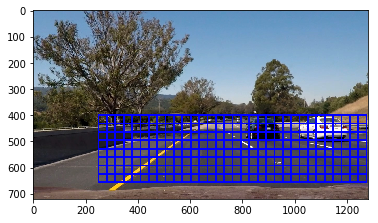

In [10]:
from p5lib.detection import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test6.jpg')

y_start_stop = (400, 660)
x_start_stop = (250, 1280)
xy_window=(64, 64)
xy_overlap=(0.5, 0.5)

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

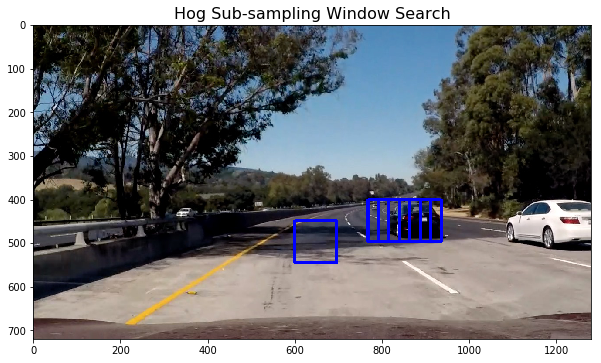

In [13]:
from p5lib.visualize import plt_one
from p5lib.detection import *
import matplotlib.image as mpimg
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Load training parameters
svc_pickle = pickle.load( open("p5lib/svc_pickle.p", "rb" ) )
#svc_pickle = pickle.load( open("p5lib/linear_svc_pickle.p", "rb" ) )
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]

# Load test image
image = mpimg.imread('test_images/test5.jpg')

ystart = 400
ystop = 660
scale = 1.5
    
out_image, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Save list of detected boxes
pickle.dump(bbox_list, open( "p5lib/bbox_pickle.p", "wb" ) )

# Visualize
figure = plt_one(out_image,'Hog Sub-sampling Window Search', figsize=(10,10), fontsize=16)
figure.savefig('output_images/hog_subsampling_example.jpg')   # save the figure to file
plt.close(figure)    # close the figure

HOG sub-sampling

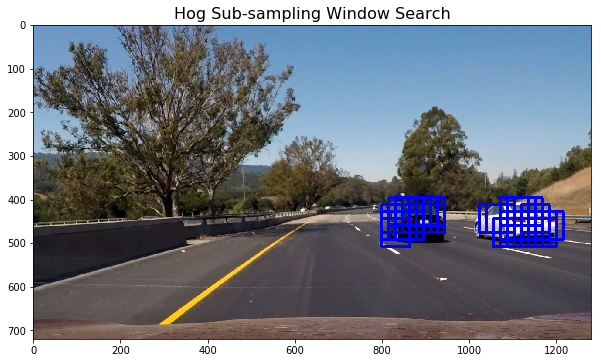

In [18]:
from p5lib.visualize import plt_one
from p5lib.detection import *
import matplotlib.image as mpimg
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Load training parameters
svc_pickle = pickle.load( open("p5lib/svc_pickle.p", "rb" ) )
#svc_pickle = pickle.load( open("p5lib/linear_svc_pickle.p", "rb" ) )
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]

# Load test image
image = mpimg.imread('test_images/test6.jpg')
bbox_list = []
#ystart_ystop_scale = [(380, 480, 1.0), (440, 560, 1.5), (500, 660, 2.0)]
#ystart_ystop_scale = [(380, 540, 1.0), (440, 600, 1.5), (500, 660, 2.0)]
ystart_ystop_scale = [(380, 580, 1.0), (400, 600, 1.5), (460, 660, 2.0)]
out_img = np.copy(image)
for ystart, ystop, scale in ystart_ystop_scale:
    out_img, bboxes = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # add boxes to the list
    bbox_list += bboxes

# Save list of detected boxes
pickle.dump(bbox_list, open( "p5lib/bbox_pickle.p", "wb" ) )

# Visualize
figure = plt_one(out_img,'Hog Sub-sampling Window Search', figsize=(10,10), fontsize=16)
figure.savefig('output_images/hog_subsampling_example.jpg')   # save the figure to file
plt.close(figure)    # close the figure

**Create a heat map of recurring detection to combine multiple detections and remove false positives**

2 cars found


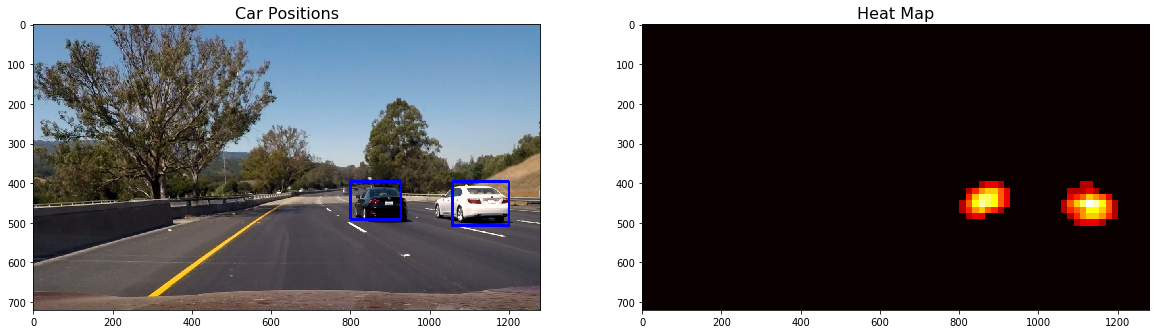

In [15]:
from p5lib.visualize import plt_two
from p5lib.detection import *
import matplotlib.image as mpimg
import numpy as np
import pickle
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
%matplotlib inline

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for the image shown above (test6.jpg)
box_list = pickle.load( open( "p5lib/bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test6.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')

#plt.imshow(labels[0], cmap='gray')

draw_image = draw_labeled_bboxes(np.copy(image), labels)

# Visualize
figure = plt_two(draw_image, heatmap, 'Car Positions', 'Heat Map', figsize=(20,20), fontsize=16, cmap_2='hot')
#figure.savefig('output_images/position_heatmap.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 5. Run the pipeline on a video stream (start with the [test_video.mp4](test_video.mp4) and later implement on full [project_video.mp4](project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles. ###

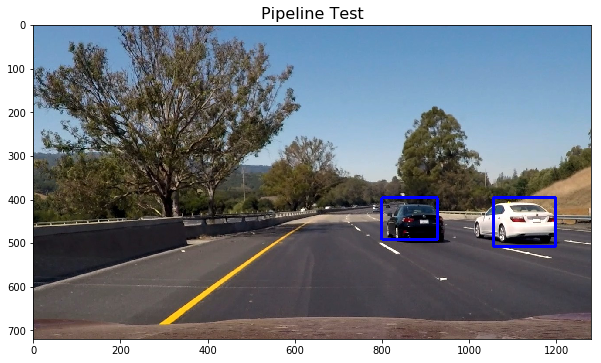

In [2]:
from p5lib.visualize import plt_one
from p5lib.detection import find_cars
from p5lib.detection import *
from scipy.ndimage.measurements import label
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

# Load training parameters
svc_pickle = pickle.load( open("p5lib/svc_pickle.p", "rb" ) )
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]

ystart_ystop_scale = [(380, 580, 1.0), (400, 600, 1.5), (460, 660, 2.0)]
proc_step = 10
frame_num = 0

def pipeline(image):
    # glabal var to keep track of labels
    global last_labels, frame_num
    
    #out_image, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = []
    out_img = np.copy(image)
    for ystart, ystop, scale in ystart_ystop_scale:
        out_img, bboxes = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list += bboxes
        
    if frame_num % proc_step == 0:
        # Add heat to each box in box list
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, bbox_list)
    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        last_labels = labels
        result = draw_labeled_bboxes(np.copy(image), labels)
    else:
        result = draw_labeled_bboxes(np.copy(image), last_labels)
        
    frame_num += 1    
    return result

# Test pipeline
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = pipeline(image)
figure = plt_one(result, "Pipeline Test", figsize=(10,10), fontsize=16)
plt.close(figure)    # close the figure
figure.savefig('output_images/test_pipeline.jpg')   # save the figure to file
plt.close(figure)    # close the figure


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [4]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [09:59<00:16, 16.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 10min 1s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))